# Final exam code

The source code for resolving the exercises of the final exam for GRA4153 question 3

## Dependencies for the code
Feel free to colapse this header for clearity

For this code, the following libraries are necessary:

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings

The Classes necessary for this notebook are defined first, then the functions used, then the main body of the code is found futher below

### Classes

In [36]:
class Data:
    def __init__(self, target_CSV: str):
        '''
        Performs the necessary ETL and stages the data into a appropriate object
        '''
        self._raw_data = pd.read_csv(target_CSV)

        # Ensure observation_date is datetime
        self._raw_data['observation_date'] = pd.to_datetime(self._raw_data['observation_date'])
        self._raw_data.set_index('observation_date', inplace=True)
        self._sample = self._raw_data
        self._diffed = self._sample
        
    def set_sample_range(self, start_date: str, end_date: str):
        '''
        A setter method for the sample attribute that filters the raw data based on a date range.
        
        :param start_date: The start date for filtering
        :type start_date: str
        :param end_date: The end date for filtering
        :type end_date: str
        '''
        self._sample = self._raw_data.loc[start_date:end_date]
        self._diffed = self._sample.diff().dropna()
        
    @property
    def sample(self):
        return self._sample
    
    @property
    def diffed(self):
        return self._sample.diff().dropna()

### Functions

In [37]:
def test_unit_root(df):
    '''
    Performs a unit test on a time series.
    
    :param df: DataFrame with time series data
    :type df: pd.DataFrame
    
    Prints:
    Test statistic, p-value, and conclusion about stationarity.
    '''
    # Run ADF test
    result = adfuller(df)

    # Unpack results
    test_statistic = result[0]
    p_value = result[1]
    used_lags = result[2]
    n_obs = result[3]
    critical_values = result[4]
    ic_best = result[5]

    # Print results
    print("ADF Test Statistic:", test_statistic)
    print("p-value:", p_value)
    print("Used Lags:", used_lags)
    print("Number of Observations:", n_obs)
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"   {key}: {value:.4f}")
    print("Information Criterion (best):", ic_best)

    # Conclusion
    if p_value < 0.05:
        print("\nConclusion: Reject the null hypothesis — the series is stationary.")
    else:
        print("\nConclusion: Fail to reject the null hypothesis — the series has a unit root (nonstationary).")

In [38]:
def plot_acf_pacf(df, lags=40):
    '''
    Plots ACF and PACF of the first-differenced INDPRO series.

    :param df: DataFrame with time series data
    :type df: pd.DataFrame
    :param lags: Number of lags to include in the plots
    :type lags: int
    :return: A plot with ACF and PACF together
    '''
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    plot_acf(df['INDPRO'], lags=lags, ax=axes[0])
    axes[0].set_title('ACF of Differenced INDPRO')

    plot_pacf(df['INDPRO'], lags=lags, ax=axes[1], method='ywm')
    axes[1].set_title('PACF of Differenced INDPRO')

    plt.tight_layout()
    

In [39]:
def correct_aic(model_result):
    '''
    Computes AICC from a fitted ARIMA model result.

    :param model_result: Fitted ARIMA model result
    '''
    n = model_result.nobs
    k = model_result.df_model
    aic = model_result.aic
    return aic + (2 * k * (k + 1)) / (n - k - 1)

In [40]:
def fit_arma_models(series, max_order=4):
    '''
    Fits ARMA(p,q) models to differenced INDPRO series and compares AICC and BIC.

    :param df: DataFrame with differenced time series
    :type df: pd.DataFrame
    :param max_order: Maximum value for p and q
    :type max_order: int

    Returns:
    pd.DataFrame: Table of (p,q), AICC, BIC
    '''
    results = []
    warnings.filterwarnings("ignore") # So many warning otherwise

    for p in range(max_order + 1):
        for q in range(max_order + 1):
            try:
                model = ARIMA(series, order=(p, 0, q))
                result = model.fit()
                aicc = correct_aic(result)
                bic = result.bic
                results.append({'p': p, 'q': q, 'AICC': aicc, 'BIC': bic})
            except Exception as e:
                continue  # Skip models that fail to converge

    return pd.DataFrame(results)

In [41]:
def plot_forcast(model, timeseries , steps=4):
    '''
    Plots the forecasted values along with confidence intervals.

    :param model: Fitted ARIMA model
    :param timeseries: Differenced time series data
    :param steps: Number of steps to forecast
    :type steps: int
    Returns:
    Plot of forecasted values with confidence intervals
    '''
    # Forecast
    forecast_result = model.get_forecast(steps=steps)
    fitted_diff = model.fittedvalues
    fitted_levels = fitted_diff.cumsum() + timeseries['INDPRO'].iloc[0]

    # Get forecasted mean and confidence intervals
    forecast_diff = forecast_result.predicted_mean
    conf_int_diff = forecast_result.conf_int()

    # Convert forecasts back to original scale
    last_observed = timeseries['INDPRO'].iloc[-1]
    forecast_original = last_observed + forecast_diff.cumsum()
    conf_int_original = conf_int_diff.cumsum() + last_observed

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(timeseries.index, timeseries['INDPRO'], label='Observed', color='blue', alpha=0.6)
    plt.plot(fitted_levels.index, fitted_levels, label='Fitted Model', color='orange', linestyle='--')
    plt.plot(forecast_original.index, forecast_original, label='Forecast', color='orange', linestyle='--')
    plt.fill_between(conf_int_original.index,
                     conf_int_original.iloc[:, 0],
                     conf_int_original.iloc[:, 1],
                     color='gray', alpha=0.3, label='95% Confidence Interval')
    plt.title('INDPRO Forecast')
    plt.xlabel('Date')
    plt.ylabel('INDPRO')
    plt.legend()
    plt.show()

## Main code

### Q3.i
Selecting the correct sample for evaluating

In [42]:
indpro = Data("indpro.csv")
indpro.set_sample_range("1970-01-01", "2015-12-01")
indpro.sample.head(20)

,INDPRO
observation_date,
1970-01-01,37.9288
1970-02-01,37.9038
1970-03-01,37.8546
1970-04-01,37.7573
1970-05-01,37.7133
1970-06-01,37.5913
1970-07-01,37.6836
1970-08-01,37.6164
1970-09-01,37.3571


<Axes: title={'center': 'Time Series of INDPRO'}, xlabel='Date', ylabel='INDPRO'>

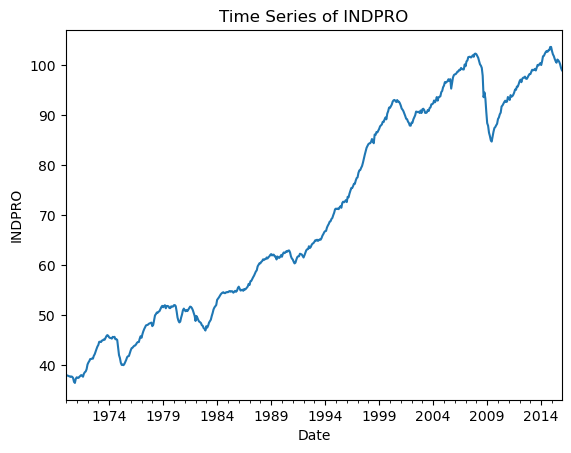

In [43]:
indpro.sample["INDPRO"].plot(title='Time Series of INDPRO', ylabel='INDPRO', xlabel='Date')

### Q3.ii
Testing for unit root of INDPRO data

In [44]:
test_unit_root(indpro.sample)

ADF Test Statistic: -1.0482117364544745
p-value: 0.7352768013756509
Used Lags: 4
Number of Observations: 547
Critical Values:
   1%: -3.4424
   5%: -2.8668
   10%: -2.5696
Information Criterion (best): 684.5104405539611

Conclusion: Fail to reject the null hypothesis — the series has a unit root (nonstationary).


### Q.iii
Correcting for the unit root

In [45]:
test_unit_root(indpro.diffed)

ADF Test Statistic: -6.561947563095948
p-value: 8.338738663782002e-09
Used Lags: 3
Number of Observations: 547
Critical Values:
   1%: -3.4424
   5%: -2.8668
   10%: -2.5696
Information Criterion (best): 682.0742060108141

Conclusion: Reject the null hypothesis — the series is stationary.


### Q.iv
Ploting ACF and PACF

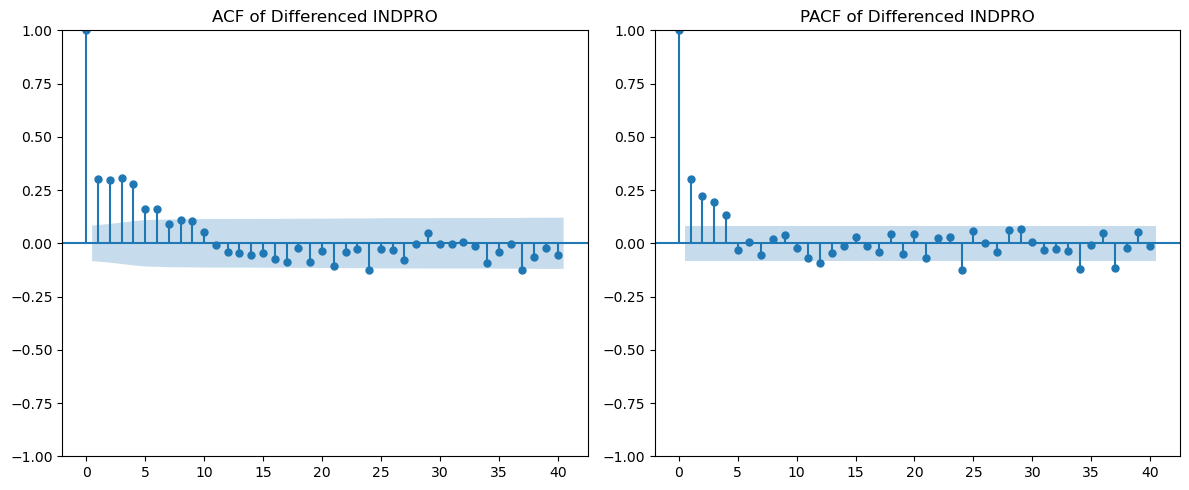

In [46]:
plot_acf_pacf(indpro.diffed)

### Q.v
Model selection

In [47]:
result_table = fit_arma_models(indpro.diffed)
result_table.sort_values(by='AICC')

,p,q,AICC,BIC
20,4,0,701.435298,727.151295
18,3,3,701.806407,736.034603
21,4,1,702.882370,732.858252
8,1,3,703.732696,729.448693
17,3,2,704.536453,734.512335
22,4,2,704.653864,738.882060
24,4,4,704.744918,747.454859
16,3,1,705.028831,730.744828
12,2,2,705.183395,730.899392
14,2,4,705.185280,739.413476


In [48]:
result_table.sort_values(by='BIC')

,p,q,AICC,BIC
6,1,1,708.320988,725.494667
20,4,0,701.435298,727.151295
7,1,2,706.070507,727.519089
11,2,1,707.195416,728.643999
8,1,3,703.732696,729.448693
16,3,1,705.028831,730.744828
12,2,2,705.183395,730.899392
15,3,0,709.593920,731.042503
21,4,1,702.882370,732.858252
17,3,2,704.536453,734.512335


### Q3.vi
Estimating the model

In [49]:
arma = ARIMA(indpro.diffed, order=(1, 0, 1)).fit()
arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 INDPRO   No. Observations:                  551
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -350.124
Date:                Wed, 03 Dec 2025   AIC                            708.248
Time:                        22:30:58   BIC                            725.495
Sample:                    02-01-1970   HQIC                           714.987
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1044      0.063      1.666      0.096      -0.018       0.227
ar.L1          0.8716      0.030     29.003      0.000       0.813       0.930
ma.L1         -0.6484      0.041    -15.845      0.000      -0.729      -0.568
sigma2         0.2086      0.005     39.883      0.000       0.198       0.219
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):              2792.54
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               2.45   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Q3.vii
Forcasting

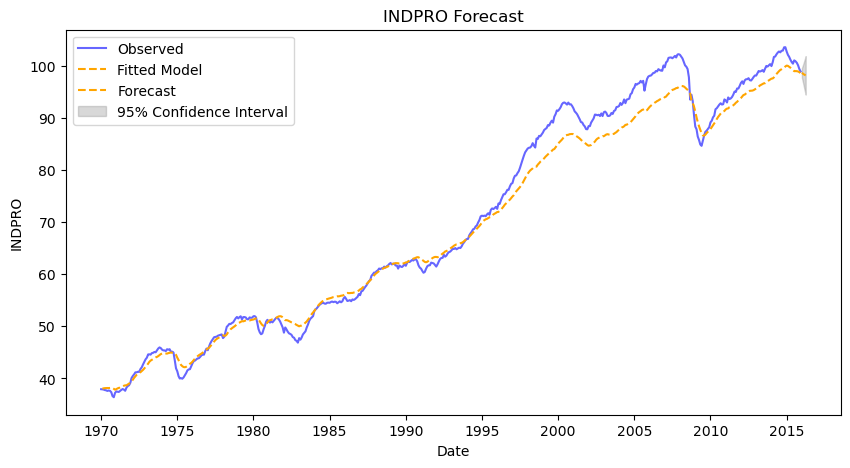

In [50]:
plot_forcast(arma, indpro.sample, steps=4)